# Assignment 3

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [202]:
# reading data

d = pd.read_csv('./data_assignment3.csv')

xValues = d['phi']
yValues = d['psi']

d_PRO = pd.DataFrame(d.loc[d['residue name'] == 'PRO'])

set(d['residue name'].values)

{'ALA',
 'ARG',
 'ASN',
 'ASP',
 'CYS',
 'GLN',
 'GLU',
 'GLY',
 'HIS',
 'ILE',
 'LEU',
 'LYS',
 'MET',
 'PHE',
 'PRO',
 'SER',
 'THR',
 'TRP',
 'TYR',
 'VAL'}

# Visualizing distribution

## Scatter plot

/var/folders/44/4j60h7j564n5nnx59bcmn4bm0000gn/T/ipykernel_8285/1659015254.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


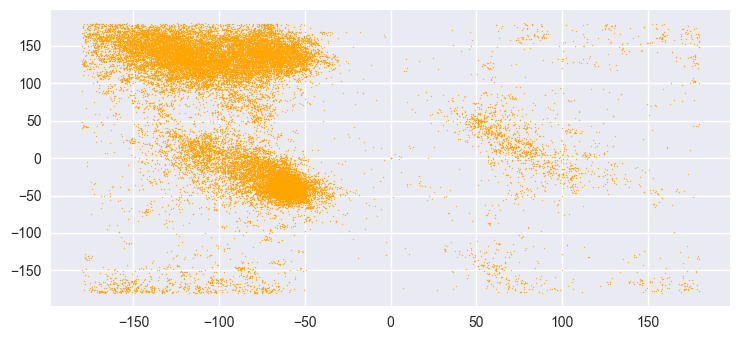

In [181]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.scatter(xValues,yValues,s=0.5, alpha=0.8, c='orange')

plt.show()

## 2D histogram

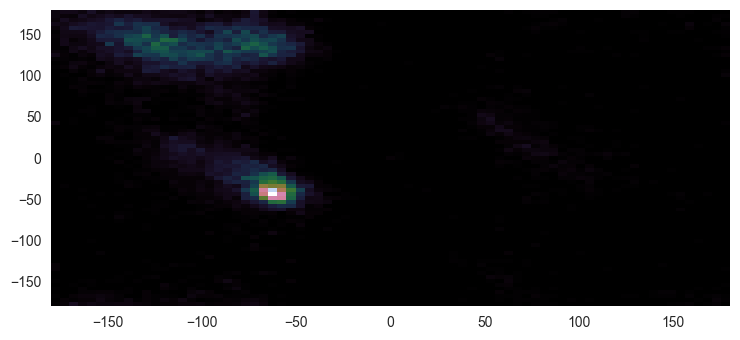

In [211]:
plt.hist2d(xValues, yValues, 75, cmap="cubehelix")
plt.show()

# 2) KMeans

best fit is: (3, 0.6724895253169637)


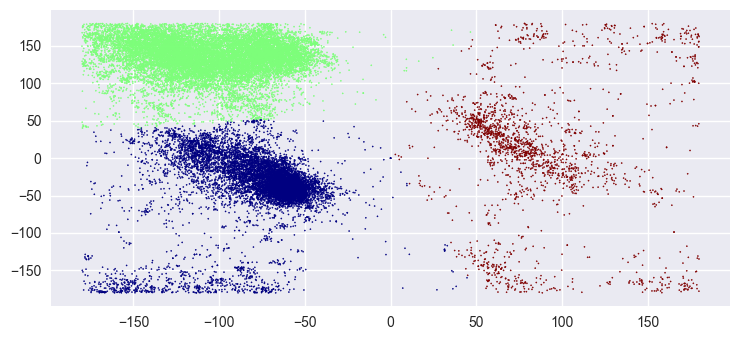

In [204]:
xy_vals = list(zip(xValues, yValues))
X = np.array(xy_vals)

score = -1
best_fit = (0, 0, 0)
for n_clusters in range(2, 5):
    kmeans = KMeans(n_clusters, n_init=10).fit_predict(X)
    new_score = silhouette_score(X, kmeans)
    if new_score > score:
        score = new_score
        best_fit = (n_clusters, score)
        d['color_kmeans'] = kmeans
 
plt.scatter(d['phi'], d['psi'], c=d['color_kmeans'], s=0.7,cmap='jet')

print(f'best fit is: {best_fit}')
plt.show()

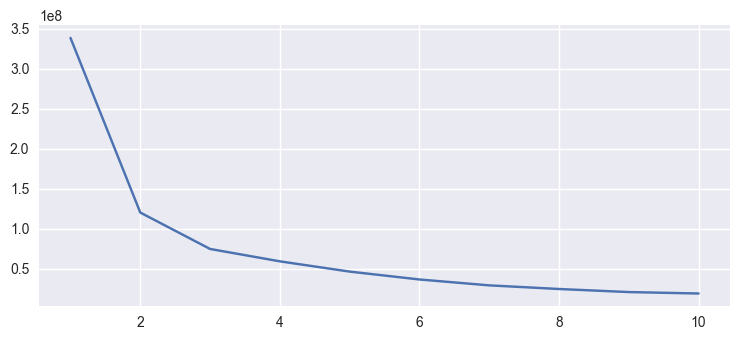

In [184]:
wcss = []

for i in range(1, 11):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
    
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sns.lineplot(x = ks, y = wcss)
plt.show()

a) We chose k=3 based on the elbow diagram and silouette score. First we used the elbow diagram to approximate the k value, then we used the siluette score to iterate through values close to our approcomation to fint the k value with the highest score. 

b) Our clusters seems fairly resonable since they have sperated the most obvious clusters. However as it is a k-means clustering all the noice have also been assignet to a cluster. That is not ideal. Also the angles at the bottom and top of the scatter plot are accually next to each other, but our k-means clustering have not managed to take this into account. 

# 3) DBSCAN

best epsilon: 30
best min samples: 800
0.6305857241669641
3


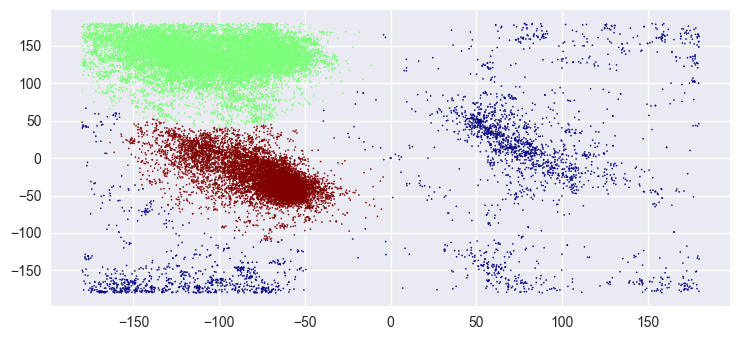

In [205]:
# computing the DBSCAN

best_e = 0 
best_l = 0
best_sc = 0
best_ms = 0

for e in range(10, 50, 10):
    for ms in range(200, 1000, 200):
        labels = DBSCAN(eps=e, min_samples=ms).fit_predict(X)
        if len(set(labels)) > 1:
            sc = silhouette_score(X, labels)
            if  sc > best_sc:
                best_sc = sc
                best_e = e
                best_l = labels
                best_ms = ms
            
d['color_dbscan'] = best_l
print(f'best epsilon: {best_e}')
print(f'best min samples: {best_ms}')
print(best_sc)

plt.scatter(d['phi'], d['psi'], c=d['color_dbscan'], s=0.7,cmap='jet')
print(len(set(best_l)))


# best epsilon: 11
# best min samples: 70

0.621844588569687


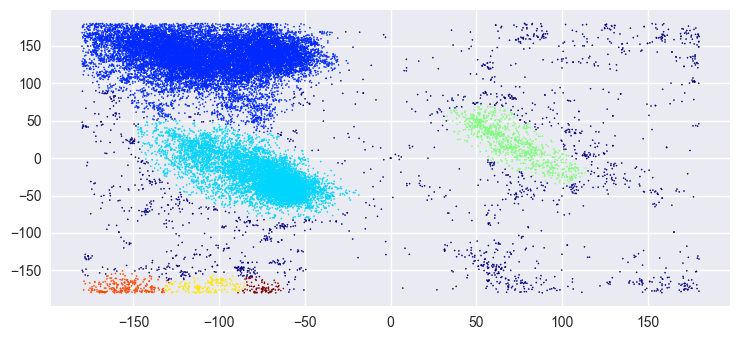

In [187]:
# plotting the best DBScan

labels = DBSCAN(eps=11, min_samples=70).fit_predict(X)
if len(set(labels)) > 1:
    d['color_dbscan'] = labels
    sc = silhouette_score(X, labels)
    print(sc)

d['color_dbscan'] = labels

plt.scatter(d['phi'], d['psi'], c=d['color_dbscan'], s=0.7,cmap='jet')
plt.show()


In [188]:
# counting the number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1) 

print('Estimated number of clusters: %d' % n_clusters_) 
print('Estimated number of noise points: %d' % n_noise_) 


Estimated number of clusters: 6
Estimated number of noise points: 1824


a) We chose eps and minimum num of sample points based on the silouette score. First we tried a few diffrent values to understand what was resonable in this context, we didnt want more than 10 clusters and also not too much noise. We iterated throught diffrent values for eps and min samples and found that eps sould be 11 and min sample should be 70. That combination achieved a silouette score of 0.6218, wich is acceptable.

The clusters 

b)

c) According to this clustering we have found 1878 noise points/outliers. 

# DBSCAN with only residue type PRO

## Plot data

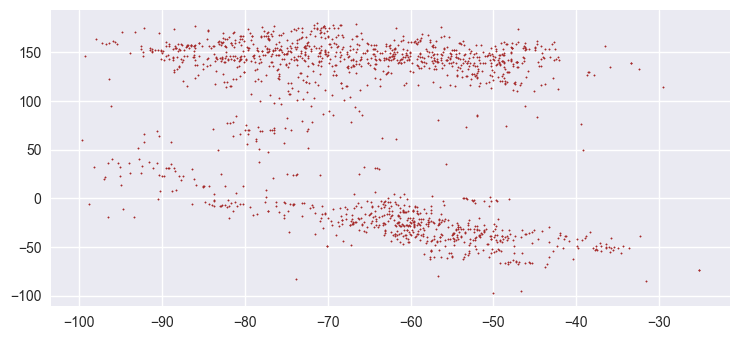

In [206]:
# reading data

d = pd.read_csv('./data_assignment3.csv')

xValues = d['phi']
yValues = d['psi']

d_PRO = pd.DataFrame(d.loc[d['residue name'] == 'PRO'])

d_PRO.drop(d_PRO[d_PRO['psi'] < -100].index, inplace=True)
d_PRO.drop(d_PRO[d_PRO['phi'] > 0].index, inplace=True)
d_PRO.drop(d_PRO[d_PRO['phi'] < -100].index, inplace=True)



plt.scatter(d_PRO['phi'], d_PRO['psi'], s=1, c='brown')

## DBSCAN on PRO data

best epsilon: 38
best min samples: 130
0.7962804746817632
Estimated number of clusters: 2
Estimated number of noise points: 0
2


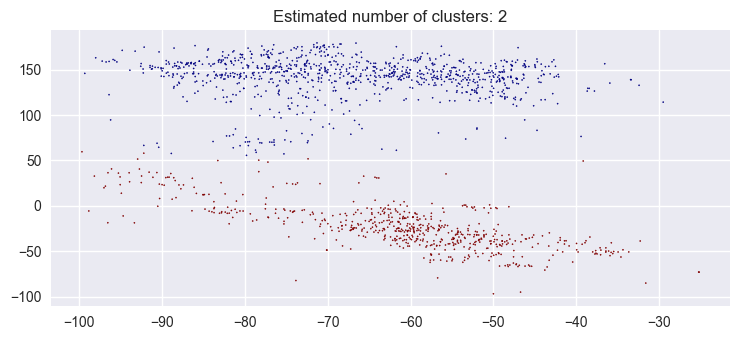

In [207]:


xy_PROvals = list(zip(d_PRO['phi'], d_PRO['psi']))
XPRO = np.array(xy_PROvals)

# computing the DBSCAN

best_e = 0 
best_l = 0
best_sc = 0
best_ms = 0
for e in range(30, 55, 1):
    for ms in range(50, 500, 10):
        labels = DBSCAN(eps=e, min_samples=ms).fit_predict(XPRO)
        if len(set(labels)) > 1:
            sc = silhouette_score(XPRO, labels)
            if  sc > best_sc:
                best_sc = sc
                best_e = e
                best_l = labels
                best_ms = ms
                
d_PRO['color_dbscan'] = best_l
print(f'best epsilon: {best_e}')
print(f'best min samples: {best_ms}')
print(best_sc)
d_PRO['color_dbscan'] = best_l
n_clusters_ = len(set(best_l)) - (1 if -1 in best_l else 0)
n_noise_ = list(best_l).count(-1)
print('Estimated number of clusters: %d' % n_clusters_) 
print('Estimated number of noise points: %d' % n_noise_)

plt.scatter(d_PRO['phi'], d_PRO['psi'], c=d_PRO['color_dbscan'], s=0.7,cmap='jet')
plt.title('Estimated number of clusters: %d' % n_clusters_) 
print(len(set(best_l)))